# Redoing Bedny (2019) analysis, comparing to word embeddings

## Load ppt data

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [51]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  # makes figs nicer!

In [2]:
df_participant_judgments = pd.read_csv("data/datalong_CBSAMT.csv")

In [3]:
df_participant_judgments.head(5)

,C1,C2,S1,S2,Category,V1,V2,S_01,S_02,S_03,...,CB_31,CB_32,CB_33,CB_34,CB_35,CB_37,CB_38,CB_40,CB_41,AMT_av
0,Sound,Sound,Sanim,Sinanim,Emission,bark,beep,1,3,4,...,1,1.0,1.0,1.0,2.0,1.0,2,1.0,2.0,2.351351
1,Sound,Sound,Sanim,Sanim,Emission,bark,bellow,1,5,5,...,1,4.0,4.0,7.0,4.0,4.0,3,1.0,5.0,4.705882
2,Sound,Light,Sanim,Light,Emission,bark,blaze,1,1,1,...,1,1.0,1.0,6.0,1.0,1.0,1,1.0,5.0,2.184211
3,Sound,Light,Sanim,Light,Emission,bark,blink,1,1,4,...,1,1.0,1.0,7.0,1.0,1.0,1,1.0,2.0,1.657895
4,Sound,Sound,Sanim,Sinanim,Emission,bark,boom,2,3,4,...,1,1.0,1.0,6.0,1.0,4.0,3,1.0,5.0,4.228571


In [4]:
len(df_participant_judgments)

2806

### Merge with cosine distances for each wordpair

In [5]:
df_analysis = pd.read_csv("data/processed/verb_embedding_distances.csv")
df_analysis.head(5)

,Unnamed: 0,cosine_distance,w1,w2
0,0,0.900461,blaze,blink
1,1,0.780368,blaze,flare
2,2,0.929387,blaze,flash
3,3,0.865661,blaze,flicker
4,4,0.856313,blaze,gleam


In [6]:
def combine_words(row, word1='w1', word2='w2'):
    w1, w2 = row[word1], row[word2]
    return '_'.join(sorted([w1, w2]))

In [7]:
df_participant_judgments['combined_words'] = df_participant_judgments.apply(
    lambda row: combine_words(row, word1='V1', word2='V2'), axis=1)

In [8]:
df_analysis['combined_words'] = df_analysis.apply(lambda row: combine_words(row), axis=1)

In [9]:
df_analysis_subset = df_analysis[df_analysis['combined_words'].isin(list(df_participant_judgments['combined_words']))]

In [10]:
df_merged = pd.merge(df_analysis, df_participant_judgments)
df_merged['same_modality'] = df_merged['C1'] == df_merged['C2']

In [11]:
df_merged.head(5)

,Unnamed: 0,cosine_distance,w1,w2,combined_words,C1,C2,S1,S2,Category,...,CB_32,CB_33,CB_34,CB_35,CB_37,CB_38,CB_40,CB_41,AMT_av,same_modality
0,0,0.900461,blaze,blink,blaze_blink,Light,Light,Light,Light,Emission,...,1.0,3.0,1.0,1.0,1.0,3,1.0,2.0,2.000,True
1,1,0.780368,blaze,flare,blaze_flare,Light,Light,Light,Light,Emission,...,4.0,4.0,7.0,4.0,7.0,5,7.0,6.0,4.725,True
2,2,0.929387,blaze,flash,blaze_flash,Light,Light,Light,Light,Emission,...,5.0,4.0,7.0,3.0,7.0,4,4.0,6.0,4.025,True
3,3,0.865661,blaze,flicker,blaze_flicker,Light,Light,Light,Light,Emission,...,2.0,3.0,1.0,1.0,7.0,3,3.0,3.0,3.750,True
4,4,0.856313,blaze,gleam,blaze_gleam,Light,Light,Light,Light,Emission,...,2.0,3.0,4.0,1.0,7.0,5,5.0,4.0,3.225,True


In [12]:
df_merged.to_csv("data/processed/judgments_with_embeddings.csv")

## Do cosine distances predict average similarity judgments?

In [13]:
import statsmodels.formula.api as sm

### Amazon Turk baseline

As cosine distance increases (*less* similar meanings, average rating of similarity on Amazon Turk decreases).

In [15]:
result = sm.ols(formula="AMT_av ~ cosine_distance", data=df_merged).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 AMT_av   R-squared:                       0.091
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     203.3
Date:                Thu, 02 May 2019   Prob (F-statistic):           5.10e-44
Time:                        09:18:02   Log-Likelihood:                -3073.9
No. Observations:                2027   AIC:                             6152.
Df Residuals:                    2025   BIC:                             6163.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.4571      0.197     27.676      0.000       5.070       5.844
cosine_distance    -3.3726      0.237    -14.257      0.000      -3.837      -2.909
==============================================================================
Omnibus:                      230.117   Durbin-Watson:                   0.858
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              313.258
Skew:                           0.956   Prob(JB):                     9.48e-69
Kurtosis:                       3.223   Cond. No.                         16.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Sighted participants' judgments

As cosine distance increases (*less* similar meanings, average similarity judgments among sighted participants decreases).

In [17]:
sighted_columns = ['S_01', 'S_02', 'S_03', 'S_04', 'S_05', 'S_07',
       'S_08', 'S_09', 'S_10', 'S_11', 'S_12', 'S_13', 'S_14', 'S_16', 'S_17',
       'S_18', 'S_19', 'S_20', 'S_21', 'S_22', 'S_23', 'S_24']
blind_columns = ['CB_06',
       'CB_08', 'CB_09', 'CB_14', 'CB_15', 'CB_18', 'CB_19', 'CB_22', 'CB_23',
       'CB_24', 'CB_25', 'CB_26', 'CB_27', 'CB_28', 'CB_29', 'CB_30', 'CB_31',
       'CB_32', 'CB_33', 'CB_34', 'CB_35', 'CB_37', 'CB_38', 'CB_40', 'CB_41']

In [18]:
def get_group_average(row, columns):
    row = row.fillna(0)
    row_col = row[columns].values
    # row_col = [i for i in row_col if i >0 ]
    return row_col.mean()

In [19]:
df_merged['blind_avg'] = df_merged.apply(lambda x: get_group_average(x, columns=blind_columns), 
                                         axis=1)

In [20]:
df_merged['sighted_avg'] = df_merged.apply(lambda x: get_group_average(x, columns=sighted_columns), 
                                         axis=1)

In [21]:
result = sm.ols(formula="sighted_avg ~ cosine_distance", data=df_merged).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            sighted_avg   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.056
Method:                 Least Squares   F-statistic:                     121.1
Date:                Thu, 02 May 2019   Prob (F-statistic):           2.16e-27
Time:                        09:19:03   Log-Likelihood:                -3105.8
No. Observations:                2027   AIC:                             6216.
Df Residuals:                    2025   BIC:                             6227.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.6971      0.200     23.449      0.000       4.304       5.090
cosine_distance    -2.6443      0.240    -11.003      0.000      -3.116      -2.173
==============================================================================
Omnibus:                      189.592   Durbin-Watson:                   0.661
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              243.184
Skew:                           0.843   Prob(JB):                     1.56e-53
Kurtosis:                       2.801   Cond. No.                         16.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Blind participants' judgments

As cosine distance increases (*less* similar meanings, average similarity judgments among blind participants decreases).

In [22]:
result = sm.ols(formula="blind_avg ~ cosine_distance", data=df_merged).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              blind_avg   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     163.1
Date:                Thu, 02 May 2019   Prob (F-statistic):           5.57e-36
Time:                        09:19:44   Log-Likelihood:                -3069.4
No. Observations:                2027   AIC:                             6143.
Df Residuals:                    2025   BIC:                             6154.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           4.9243      0.197     25.029      0.000       4.538       5.310
cosine_distance    -3.0145      0.236    -12.771      0.000      -3.477      -2.552
==============================================================================
Omnibus:                      206.743   Durbin-Watson:                   0.817
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              273.417
Skew:                           0.896   Prob(JB):                     4.25e-60
Kurtosis:                       3.156   Cond. No.                         16.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Discussion

The cosine distance between words in vector-space significantly predicts the average similarity ratings for:

1. Amazon Mechanical Turk participants (R^2=.09)  
2. Sighted participants in the lab (R^2=.06)  
3. Blind participants in the lab (R^2=.075)

This is evidence that at least *some* of what participants know about the similarity of word meanings can be explained in terms of those words' distributional patterns. 

## Do PCA-reduced embeddings predict MDS-scaled similarity judgments?

### Hierarchical clustering 

In [9]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [10]:
# Deal with NA rows
df_merged = df_merged.fillna(0)

In [11]:
X_sighted = df_merged[sighted_columns]
X_blind = df_merged[blind_columns]

In [12]:
linked_sighted = linkage(X_sighted, 'ward')
linked_blind = linkage(X_blind, 'ward')

In [13]:
len(linked_sighted)

2026

### Multidimensional scaling

Now we replicate the MDS-scaling on the similarity judgments for each item for blind and sighted participants, using four dimensions:

"Based on this heuristic, we report the results of basic MDS models fit with 4 dimensions." (pg. 109).

In [28]:
from sklearn.manifold import MDS

In [29]:
df_merged = df_merged.fillna(0)

In [30]:
X_sighted = df_merged[sighted_columns]
X_blind = df_merged[blind_columns]

In [31]:
embedding = MDS(n_components=4)
X_sighted_transformed = embedding.fit_transform(X_sighted)

In [33]:
df_mds_sighted = pd.DataFrame(X_sighted_transformed, columns=['d1', 'd2', 'd3', 'd4'])

In [35]:
X_blind_transformed = embedding.fit_transform(X_blind)
df_mds_blind = pd.DataFrame(X_blind_transformed, columns=['d1', 'd2', 'd3', 'd4'])

In [36]:
# Kind of ugly, fix later
df_merged['d1_sight'] = list(df_mds_sighted['d1'])
df_merged['d2_sight'] = list(df_mds_sighted['d2'])
df_merged['d3_sight'] = list(df_mds_sighted['d3'])
df_merged['d4_sight'] = list(df_mds_sighted['d4'])
df_merged['d1_blind'] = list(df_mds_blind['d1'])
df_merged['d2_blind'] = list(df_mds_blind['d2'])
df_merged['d3_blind'] = list(df_mds_blind['d3'])
df_merged['d4_blind'] = list(df_mds_blind['d4'])

In [37]:
df_merged.head(5)

,Unnamed: 0,cosine_distance,w1,w2,combined_words,C1,C2,S1,S2,Category,...,blind_avg,sighted_avg,d1_sight,d2_sight,d3_sight,d4_sight,d1_blind,d2_blind,d3_blind,d4_blind
0,0,0.900461,blaze,blink,blaze_blink,Light,Light,Light,Light,Emission,...,2.20,1.545455,1.526694,1.210300,-5.025918,0.248381,2.223455,1.036150,1.990462,-5.101778
1,1,0.780368,blaze,flare,blaze_flare,Light,Light,Light,Light,Emission,...,4.96,4.863636,-7.815662,-3.917927,9.172263,-1.605038,-0.562645,-11.459492,-8.521721,-2.759877
2,2,0.929387,blaze,flash,blaze_flash,Light,Light,Light,Light,Emission,...,4.40,3.909091,-5.946512,-5.775250,3.677996,-3.653852,-0.277162,-11.028081,-2.797416,0.870127
3,3,0.865661,blaze,flicker,blaze_flicker,Light,Light,Light,Light,Emission,...,3.48,3.590909,-4.360268,-4.617804,5.279388,4.146550,-1.664323,-3.533919,-0.277514,-9.861976
4,4,0.856313,blaze,gleam,blaze_gleam,Light,Light,Light,Light,Emission,...,3.52,3.954545,-7.364134,0.260002,4.543729,-3.187869,2.060951,-3.435050,-5.228298,-6.855814


In [38]:
df_merged.to_csv("data/processed/judgments_plus_mds.csv")

### Compute MDS centroids

In [39]:
df_merged = pd.read_csv("data/processed/judgments_plus_mds.csv")
df_verbs = pd.read_csv("data/processed/verbs_with_embeddings.csv")

In [44]:
import numpy as np
df_centroids = df_merged.groupby('w1').agg({
    'd1_blind': np.mean,
    'd2_blind': np.mean,
    'd3_blind': np.mean,
    'd4_blind': np.mean,
    'd1_sight': np.mean,
    'd2_sight': np.mean,
    'd3_sight': np.mean,
    'd4_sight': np.mean
}).reset_index()

In [45]:
df_centroids.head(5)

,w1,d1_blind,d2_blind,d3_blind,d4_blind,d1_sight,d2_sight,d3_sight,d4_sight
0,bark,-2.828115,-0.287135,0.554778,-1.354478,-2.081863,0.885201,0.360212,-1.686473
1,beep,-3.600926,1.543128,1.665730,-0.507831,-1.267929,1.067074,-1.240600,-0.999277
2,bellow,-3.412271,-1.070986,1.269794,-1.918467,-1.796253,1.474152,0.469891,-2.067675
3,blaze,0.624118,0.922406,-1.185959,-1.055760,-0.777373,-1.578411,-1.532679,0.447354
4,blink,0.367619,2.400966,0.272074,0.928457,1.237538,-1.544484,-3.457887,0.528423


In [46]:
df_verbs['w1'] = list(df_verbs['verb'])
df_centroid_plus_verbs = pd.merge(df_centroids, df_verbs, on="w1")

In [47]:
df_centroid_plus_verbs.head(5)

,w1,d1_blind,d2_blind,d3_blind,d4_blind,d1_sight,d2_sight,d3_sight,d4_sight,Unnamed: 0,...,CDlow,SUBTLwf,Lg10WF,SUBTLcd,Lg10CD,Length,embedding,contextualized_embedding,pc1,pc2
0,bark,-2.828115,-0.287135,0.554778,-1.354478,-2.081863,0.885201,0.360212,-1.686473,15,...,188,5.49,2.4487,2.47,2.3181,4,"[-0.17852488160133362, 0.1139930859208107, -0....","[-0.17852488160133362, 0.1139930859208107, -0....",-3.531470,-1.685536
1,beep,-3.600926,1.543128,1.665730,-0.507831,-1.267929,1.067074,-1.240600,-0.999277,30,...,178,6.51,2.5224,2.49,2.3222,4,"[-0.03189978003501892, 0.13681069016456604, 0....","[-0.03189978003501892, 0.13681069016456604, 0....",-2.437591,0.038505
2,bellow,-3.412271,-1.070986,1.269794,-1.918467,-1.796253,1.474152,0.469891,-2.067675,16,...,16,0.45,1.3802,0.25,1.3424,6,"[-0.4575001299381256, -0.163986936211586, -0.0...","[-0.4575001299381256, -0.163986936211586, -0.0...",-2.771036,-0.169398
3,blaze,0.624118,0.922406,-1.185959,-1.055760,-0.777373,-1.578411,-1.532679,0.447354,0,...,72,2.10,2.0334,0.92,1.8921,5,"[-0.03797150403261185, 0.18279701471328735, -0...","[-0.03797150403261185, 0.18279701471328735, -0...",-0.078394,-2.332131
4,blink,0.367619,2.400966,0.272074,0.928457,1.237538,-1.544484,-3.457887,0.528423,1,...,194,5.06,2.4133,2.55,2.3324,5,"[-0.2869924306869507, -1.3215936422348022, 1.4...","[-0.2869924306869507, -1.3215936422348022, 1.4...",-2.234316,2.968971


Text(0.5, 1.0, 'MDS (Sighted) for Perception verbs')

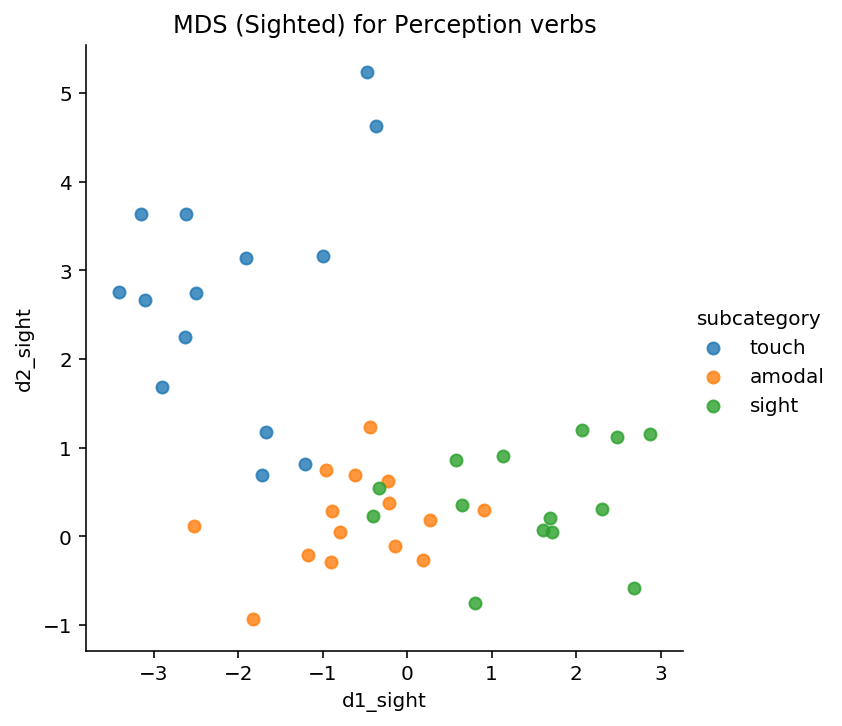

In [54]:
sns.lmplot(x="d1_sight", y="d2_sight", data=df_centroid_plus_verbs[df_centroid_plus_verbs['category']=="perception"], 
           fit_reg=False, hue='subcategory',
           legend=True)
plt.title("MDS (Sighted) for Perception verbs")

Text(0.5, 1.0, 'MDS (Blind) for Perception verbs')

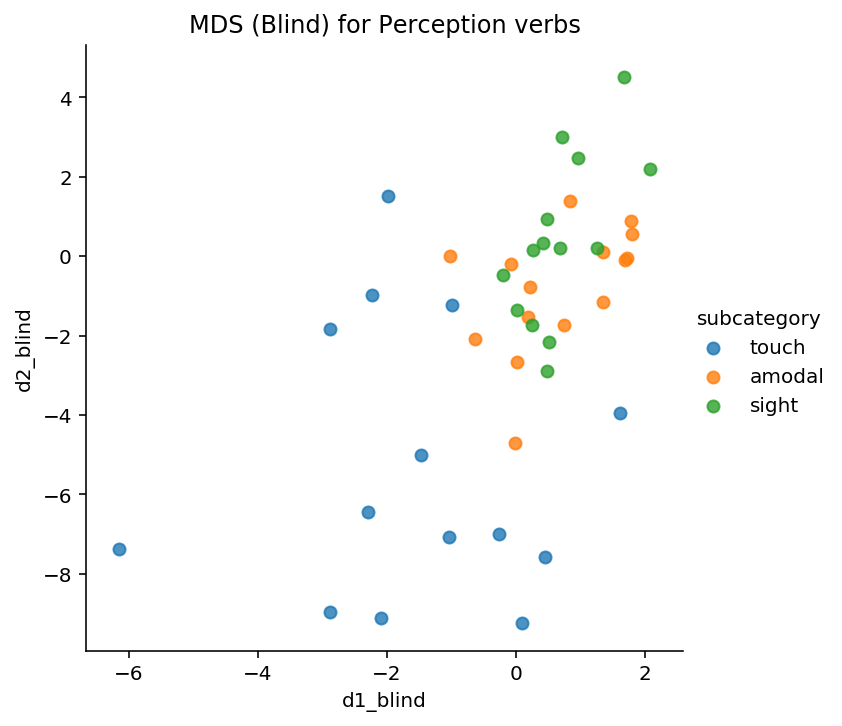

In [53]:
sns.lmplot(x="d1_blind", y="d2_blind", data=df_centroid_plus_verbs[df_centroid_plus_verbs['category']=="perception"], 
           fit_reg=False, hue='subcategory',
           legend=True)
plt.title("MDS (Blind) for Perception verbs")

Text(0.5, 1.0, 'MDS (Sighted) for Emission verbs')

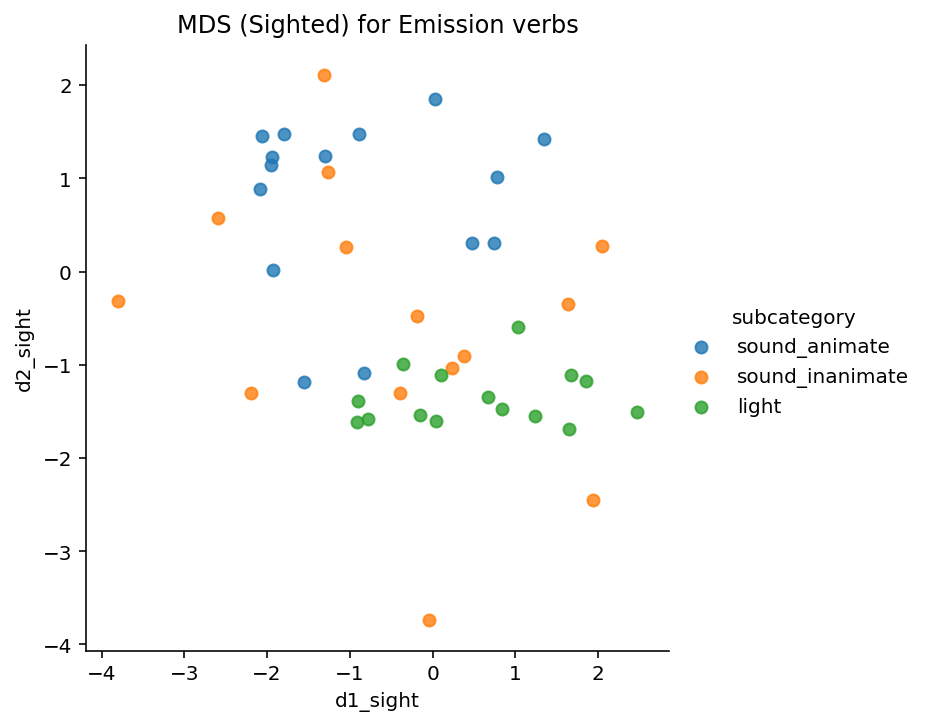

In [52]:
sns.lmplot(x="d1_sight", y="d2_sight", data=df_centroid_plus_verbs[df_centroid_plus_verbs['category']=="emission"], 
           fit_reg=False, hue='subcategory',
           legend=True)
plt.title("MDS (Sighted) for Emission verbs")

Text(0.5, 1.0, 'MDS (Blind) for Emission verbs')

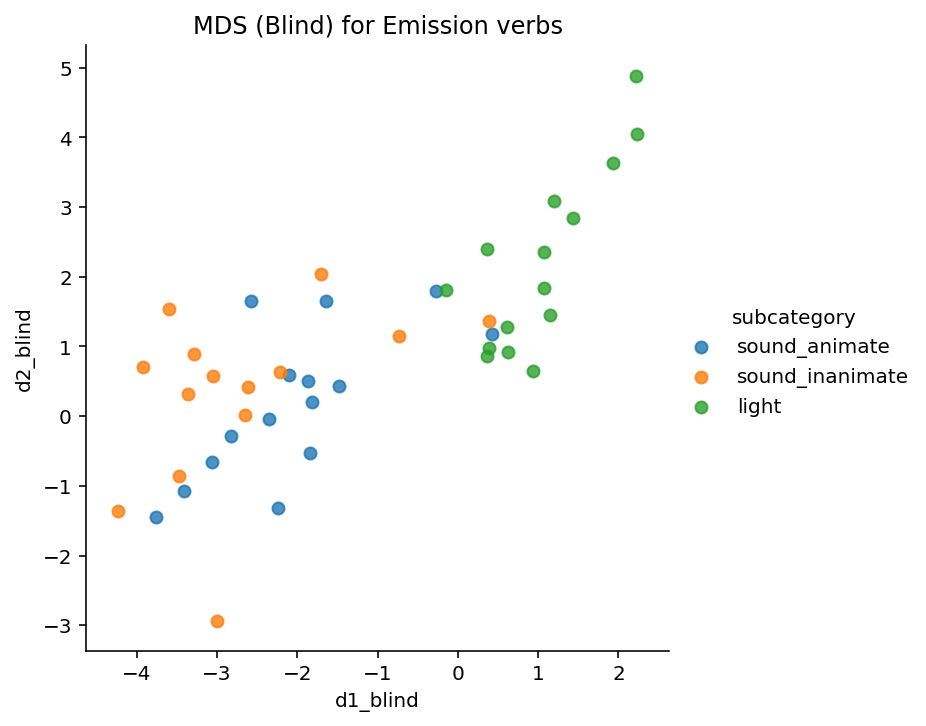

In [55]:
sns.lmplot(x="d1_blind", y="d2_blind", data=df_centroid_plus_verbs[df_centroid_plus_verbs['category']=="emission"], 
           fit_reg=False, hue='subcategory',
           legend=True)
plt.title("MDS (Blind) for Emission verbs")

### Predict MDS with PCA embeddings

Here, we predict both pretty well, and do a slightly better job predicting MDS scalings from **blind** participants than **sighted**.

In [62]:
from sklearn import linear_model

In [63]:
y_blind = df_centroid_plus_verbs[['d1_blind', 'd2_blind', 'd3_blind', 'd4_blind']].values
y_sighted = df_centroid_plus_verbs[['d1_sight', 'd2_sight', 'd3_sight', 'd4_sight']].values

X = df_centroid_plus_verbs[['pc1', 'pc2']].values

In [64]:
lm = linear_model.LinearRegression()
model = lm.fit(X,y_blind)
lm.score(X, y_blind)

0.12782723750138741

In [65]:
lm = linear_model.LinearRegression()
model = lm.fit(X,y_sighted)
lm.score(X, y_sighted)

0.12004514919402554

### Now use train/test split

In [149]:
# import ast
# X = np.array([ast.literal_eval(x) for x in df_centroid_plus_verbs['contextualized_embedding'].values])

In [150]:
X = df_centroid_plus_verbs[['pc1', 'pc2']].values

In [152]:
from sklearn.model_selection import KFold

scores = []
kf = KFold(n_splits=3)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    
    y_train_sight, y_test_sight = y_sighted[train_index], y_sighted[test_index]
    y_train_blind, y_test_blind = y_blind[train_index], y_blind[test_index]
    
    model = lm.fit(X_train,y_train_sight)
    score_sight = model.score(X_test, y_test_sight)
    
    model = lm.fit(X_train,y_train_blind)
    score_blind = model.score(X_test, y_test_blind)
    
    scores.append({
        'score_blind': score_blind,
        'score_sight': score_sight
    })

In [153]:
df_scores = pd.DataFrame(scores)

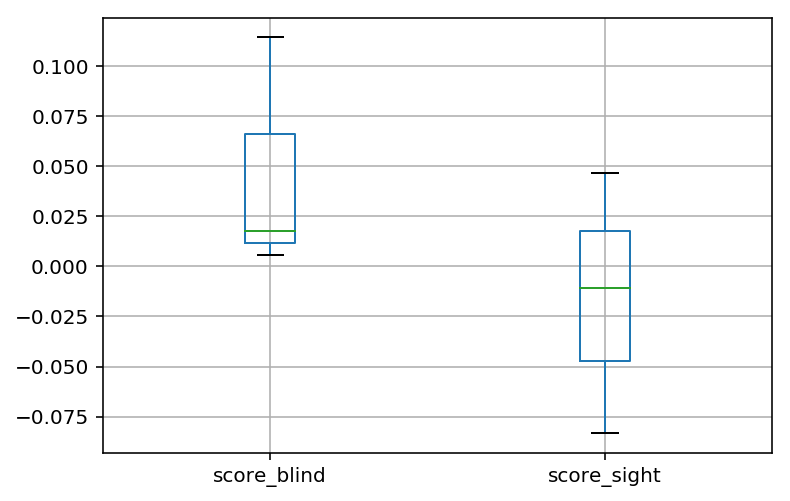

In [154]:
df_scores.boxplot()